## Exploring a Mean Reversion Strategy with Zipline Reloaded

In [1]:
import warnings

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from IPython.display import Markdown, display
from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    calendars,
    date_rules,
    get_datetime,
    get_open_orders,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    set_commission,
    set_slippage,
    time_rules,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns

In [3]:
warnings.filterwarnings("ignore")

In [4]:
N_LONGS = N_SHORTS = 50
MONTH = 21
YEAR = 12 * MONTH

Define a custom mean reversion factor

In [5]:
class MeanReversion(CustomFactor):
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

Define the pipeline for factors and securities selection

In [6]:
def make_pipeline():
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(
        columns={
            "longs": mean_reversion.bottom(N_LONGS),
            "shorts": mean_reversion.top(N_SHORTS),
            "ranking": mean_reversion.rank(ascending=False),
        },
        screen=dollar_volume.top(100),
    )

Define the function to be called before the trading starts

In [7]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")

Define the initialize function to set up the algorithm

In [8]:
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )

    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=0.01))

    set_slippage(
        us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01)
    )

Define the rebalance function to execute trades

In [9]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, "price"))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    print(
        f"{get_datetime().date()} | Longs {len(longs)} | Shorts | {len(shorts)} | {context.portfolio.portfolio_value}"
    )

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)

Define the function to execute trades

In [10]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

Define the analyze function to plot performance

In [11]:
def analyze(context, perf):
    perf.portfolio_value.plot()

Define the start and end dates for the backtest

In [12]:
start = pd.Timestamp("2016")
end = pd.Timestamp("2018")

Fetch the benchmark returns (S&P 500)

In [13]:
sp500 = web.DataReader("SP500", "fred", start, end).SP500
benchmark_returns = sp500.pct_change()

Run the algorithm

In [14]:
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    benchmark_returns=benchmark_returns,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    bundle="quandl",
)
perf.to_pickle("mean_reversion.pickle")

ValueError: no data for bundle 'quandl' on or before 2025-02-03 05:19:04.815173+00:00
maybe you need to run: $ zipline ingest -b quandl

Display the pipeline graph

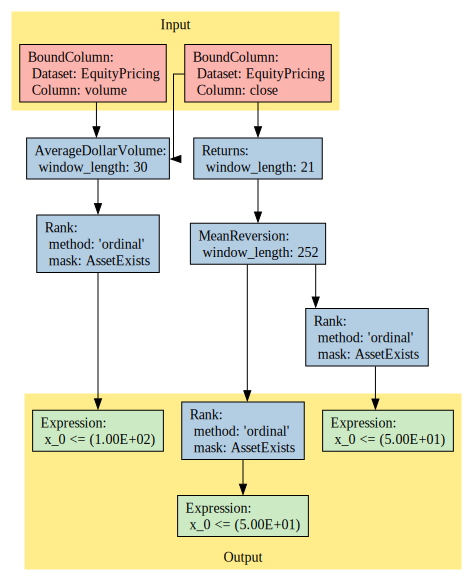

In [15]:
p = make_pipeline()
p.show_graph()

Plot beta and alpha of the portfolio

<Axes: >

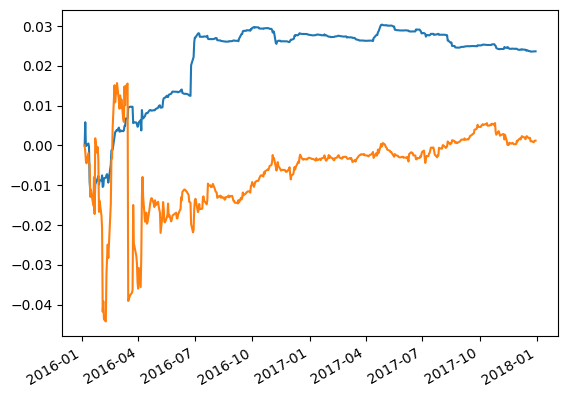

In [16]:
perf.beta.plot()
perf.alpha.plot()

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.